In [20]:
import influxdb_client, os, time
from influxdb import DataFrameClient
from datetime import datetime
import pandas as pd
from IPython.display import display, HTML,Markdown
import matplotlib.pyplot as plt
import os 

In [4]:
#setting & init
token = "RIZZsgptkpmFaqmapGn55oDyEDKVC9kDS1FkY7iLNLUINCcnpTcVTRdDAFSWmVqjUBpSo5fWuDBCGRPHYUfO2A=="
org = "metaportalweb@gmail.com"
url = "https://us-east-1-1.aws.cloud2.influxdata.com"

ronin_treasury = "a99cacd1427f493a95b585a5c7989a08c86a616b"

client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

In [80]:
with open('../ronin-indexer-rust/current_block','r+') as f:
    ronin_indexer_rust_current_block = int(f.readline())


In [8]:
## helper function
def format_df(data):
    df = data.copy()
    df['_time'] = df['_time'].apply((lambda x: pd.to_datetime(x.value)))
    df = df.set_index('_time')
    df.index.name = 'date'
    df = df[['from','to','value']]
    return df
    
def printmd(string):
    display(Markdown(string))


In [6]:
def get_df_by_bucket(bucket):
    query_api = client.query_api()

    query = f"""from(bucket: "{bucket}")
    |> range(start: -10000000000m) 
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    """


    raw= query_api.query_data_frame(query, org=org)
    df = format_df(raw)
    return df

In [24]:
def get_whales(df,folder,level=10):
    months = df.index.strftime("%Y-%m").unique()
    output_path = f'data/whales/{folder.lower()}'
    if not os.path.exists(output_path): os.mkdir(output_path)
    for month in months:
        tx_aggregate_by_month= df.loc[month].groupby('from').sum().sort_values(by='value',ascending=False)
        whales = tx_aggregate_by_month.iloc[:level]
        whales.to_json(output_path+'/'+month+'.json')

In [47]:
def flatten_tx(list_of_df):
    return pd.concat(list_of_df).drop(['to','value'],axis=1)

def gini(list_of_values):
    n = len(list_of_values)
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area * (n-1)/n

def get_gini_by_month(df):
    months = df.index.strftime("%Y-%m").unique()
    output_dict = dict()
    for month in months:
        list_of_values= df.loc['2022-06'].value_counts().values
        output_dict[month] = gini(list_of_values)
    pd.DataFrame({'gini':output_dict}).to_json('data/gini_by_month.json')

In [76]:
def get_time_zone(average_hour,assumption='8-24'):
    if assumption=='8-24':
        diff = round(average_hour - 16)
        return -diff 
    if assumption=='9-18':
        diff = round(average_hour - 13.5)
        return -diff
    if assumption=='average':
        return round(-round(average_hour - 16) + -round(average_hour - 13.5))/2
    
def get_time_zone_of_whales_by_month(df,folder,level=10): #whales separated by buckets
    months = df.index.strftime("%Y-%m").unique()
    df_copy = df.copy()
    df_copy['hour'] = pd.Series(df_copy.index.hour).values
    output_path = f'data/timezone/{folder.lower()}'
    if not os.path.exists(output_path): os.mkdir(output_path)
    for month in months:
        tx_aggregate_by_month= df_copy.loc[month].groupby('from').sum().sort_values(by='value',ascending=False)
        whales = tx_aggregate_by_month.iloc[:level]
        timezone_dict = dict()
        for address in whales.index:
            average_hour = df_copy[df_copy['from']==address]['hour'].mean()
            timezone = get_time_zone(average_hour)
            timezone_dict[address] = f'utc+{timezone}' if timezone >= 0 else f'utc{timezone}'
        pd.DataFrame({'timezone':timezone_dict}).to_json(output_path+'/'+month+'.json')

In [81]:
katana_df = get_df_by_bucket('KATANA')
gateway_df = get_df_by_bucket('GATEWAY')
breeding_df = get_df_by_bucket("BREEDING")

In [25]:
get_whales(katana_df,'KATANA')
get_whales(gateway_df,'GATEWAY')
get_whales(breeding_df,'BREEDING')

In [48]:
get_gini_by_month(flatten_tx([katana_df,gateway_df,breeding_df]))

In [77]:
get_time_zone_of_whales_by_month(katana_df,'KATANA')
get_time_zone_of_whales_by_month(gateway_df,'GATEWAY')
get_time_zone_of_whales_by_month(breeding_df,'BREEDING')

In [ ]:
query_api = client.query_api()
bucket = "GATEWAY"

query = f"""from(bucket: "{bucket}")
 |> range(start: -100m) 
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


raw_gateway = query_api.query_data_frame(query, org=org)

In [8]:
query_api = client.query_api()
bucket = "GATEWAY"

query = f"""from(bucket: "{bucket}")
 |> range(start: -10000000000m) 
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


raw_gateway = query_api.query_data_frame(query, org=org)
gateway_df = format_df(raw_gateway)

ApiException: (404)
Reason: Not Found
HTTP response headers: HTTPHeaderDict({'Date': 'Tue, 04 Oct 2022 12:46:47 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'trace-id': 'bc2c4f395ca6cb35', 'trace-sampled': 'false', 'vary': 'Accept-Encoding', 'x-platform-error-code': 'not found', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains', 'X-Influxdb-Request-ID': '82466dc49fcff7acfb4f07f539a20e24', 'X-Influxdb-Build': 'Cloud'})
HTTP response body: b'{"code":"not found","message":"failed to initialize execute state: could not find bucket \\"GATEWAY\\""}'


In [5]:
query_api = client.query_api()
bucket = "TREASURY"

query = f"""from(bucket: "{bucket}")
 |> range(start: -10000000000m) 
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


raw_treasury = query_api.query_data_frame(query, org=org)
treasury_df = format_df(raw_treasury)

In [4]:
query_api = client.query_api()
bucket = "WETH"

query = f"""from(bucket: "{bucket}")
 |> range(start: -10000000000m) 
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


raw_weth = query_api.query_data_frame(query, org=org)
weth_df = format_df(raw_weth)

In [135]:
bucket = "AXS"
query = f"""from(bucket: "{bucket}")
 |> range(start: -10000000000m) 
 |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


raw_axs = query_api.query_data_frame(query, org=org)
axs_df = format_df(raw_axs)

In [75]:
# find whales based on from tx

# WETH
weth_groupby_from = weth_df.groupby('from').sum().sort_values(by='value',ascending=False)
printmd("<div style='font-size:20px'>WETH Whales: </div>")
display(weth_groupby_from)
# AXS
axs_groupby_from = axs_df.groupby('from').sum().sort_values(by='value',ascending=False)
printmd("<div style='font-size:20px'>AXS Whales: </div>")
display(axs_groupby_from)


<div style='font-size:20px'>WETH Whales: </div>

,value
from,
d0fe56a20bc404cc743b9cad8d9245e2c658fe7e,1.655000e+03
6a0ac34a3726daff83a83e5e454a4a976e33ffac,4.588299e+02
70922ea1d3adb3fd05f9df07aa925827550ecd61,2.861162e+02
d53000053e91597add02e491536628c40c9072d8,2.340000e+02
0e8cb007d7fe291d275cd83c18b4a7eefa112d62,1.960000e+02
...,...
88b17ee35090439acf1bfb905617ccb0f26ac14d,9.996620e-13
bb007aa543514b1761d5e53058c1d23a6e696e14,1.111110e-13
b84438b49b6b672695eab37ec5a32d06ebdf3f2b,0.000000e+00


<div style='font-size:20px'>AXS Whales: </div>

,value
from,
b32e9a84ae0b55b8ab715e4ac793a61b277bafa3,5.009797e+05
030e37ddd7df1b43db172b23916d523f1599c6cb,3.455870e+05
01acad0e173d09236d2af7b013442de042827881,9.349129e+04
ecc7c35c522b4239a413f212c08d458561d004d2,8.038873e+04
5d8a9e08f14eb765b8b906cb7b7617da067d5ca1,8.036047e+04
...,...
279c3481874411d50b01635d0832a6aea4b6106e,1.615537e-08
21e7d9e5ff60dc3fc225bdb25fd808d558fab32d,1.284549e-09
5a3f3f55ee773584731674502810a4f6c3fa5081,0.000000e+00


In [76]:
# find whales based on to tx

# WETH
weth_groupby_to = weth_df.groupby('to').sum().sort_values(by='value',ascending=False)
printmd("<div style='font-size:20px'>WETH Whales: </div>")
display(weth_groupby_to)
# AXS
axs_groupby_to = axs_df.groupby('to').sum().sort_values(by='value',ascending=False)
printmd("<div style='font-size:20px'>AXS Whales: </div>")
display(axs_groupby_to)


<div style='font-size:20px'>WETH Whales: </div>

,value
to,
6a0ac34a3726daff83a83e5e454a4a976e33ffac,1.655000e+03
d0fe56a20bc404cc743b9cad8d9245e2c658fe7e,4.588289e+02
70922ea1d3adb3fd05f9df07aa925827550ecd61,2.470000e+02
553f59757e2e76cb96f457fcba38756c87b4d0b9,1.625915e+02
ad19f6ab7b487882b1ae244286c2cbebc76b64f0,1.380000e+02
...,...
bb297b294c9eae6718d151cc215407c6bcd1a53d,2.000000e-18
888045f89116c867c6fd0398c72a281980cc65f5,0.000000e+00
3afef28c419c4613cbe7d9bdd0a818d8aaa63a33,0.000000e+00


<div style='font-size:20px'>AXS Whales: </div>

,value
to,
b32e9a84ae0b55b8ab715e4ac793a61b277bafa3,7.605898e+05
3205b65a18d13360048bb90aad348ade9c06dbf3,3.455870e+05
609f5d055e9290457c8a06479bcaaa8902ddbdec,9.347306e+04
d31172d56e51078a1fdef1fea9210807ecc8bf1a,9.300099e+04
ecc7c35c522b4239a413f212c08d458561d004d2,8.038873e+04
...,...
f167b8d09556f5b8f0e5fc3468bd29b03ded93f9,5.635473e-08
05b7550b4ae4ce2185ca701ca62ba623ea221df0,5.159976e-08
926fda9042f447d4a9bf03ab828b1d67c6096682,0.000000e+00


In [98]:
#combine from and to find the whale based on associate tx

#combine 
weth_value_dict = weth_groupby_from.to_dict()
for (address,value) in weth_groupby_to.to_dict()['value'].items():
    cummulative_value = weth_value_dict['value'].get(address,0) + value
    weth_value_dict['value'][address] = cummulative_value

weth_combine_df = pd.DataFrame(weth_value_dict).sort_values(by='value',ascending=False)
weth_combine_df.index.name = 'address'

axs_value_dict = axs_groupby_from.to_dict()
for (address,value) in axs_groupby_to.to_dict()['value'].items():
    cummulative_value = axs_value_dict['value'].get(address,0) + value
    axs_value_dict['value'][address] = cummulative_value

axs_combine_df = pd.DataFrame(axs_value_dict).sort_values(by='value',ascending=False)
axs_combine_df.index.name = 'address'

printmd("<div style='font-size:20px'>WETH Whales: </div>")
display(weth_combine_df)

printmd("<div style='font-size:20px'>AXS Whales: </div>")
display(axs_combine_df)

<div style='font-size:20px'>WETH Whales: </div>

,value
address,
6a0ac34a3726daff83a83e5e454a4a976e33ffac,2113.829918
d0fe56a20bc404cc743b9cad8d9245e2c658fe7e,2113.828918
70922ea1d3adb3fd05f9df07aa925827550ecd61,533.116173
d53000053e91597add02e491536628c40c9072d8,346.616173
0e8cb007d7fe291d275cd83c18b4a7eefa112d62,196.000000
...,...
c8bae01eb82809128db75c8f9c72ed7b496f735e,0.000000
3afef28c419c4613cbe7d9bdd0a818d8aaa63a33,0.000000
888045f89116c867c6fd0398c72a281980cc65f5,0.000000


<div style='font-size:20px'>AXS Whales: </div>

,value
address,
b32e9a84ae0b55b8ab715e4ac793a61b277bafa3,1.261570e+06
030e37ddd7df1b43db172b23916d523f1599c6cb,3.455870e+05
3205b65a18d13360048bb90aad348ade9c06dbf3,3.455870e+05
ecc7c35c522b4239a413f212c08d458561d004d2,1.607775e+05
089ac289cada2b2b4156e24065b02aedcd19f2e9,1.600664e+05
...,...
5a3f3f55ee773584731674502810a4f6c3fa5081,0.000000e+00
37538e472a84520c3d7e3c713ae77fd5177a4bc8,0.000000e+00
926fda9042f447d4a9bf03ab828b1d67c6096682,0.000000e+00


In [10]:
to_treasury_tx = treasury_df[treasury_df['to']==ronin_treasury]
to_treasury_tx['date'] = to_treasury_tx.index
to_treasury_tx['month'] = to_treasury_tx['date'].apply(lambda x:x.month)

/var/folders/d1/ld5f7ltj28j_d619l3t47d780000gn/T/ipykernel_5079/4226771249.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_treasury_tx['date'] = to_treasury_tx.index
/var/folders/d1/ld5f7ltj28j_d619l3t47d780000gn/T/ipykernel_5079/4226771249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_treasury_tx['month'] = to_treasury_tx['date'].apply(lambda x:x.month)


In [11]:
# WETH to treasury 
to_treasury_tx_groupby = to_treasury_tx.drop('month',axis=1).groupby('from').sum().sort_values(by='value',ascending=False)
printmd("<div style='font-size:20px'>WETH Whales: </div>")
display(to_treasury_tx_groupby)

<div style='font-size:20px'>WETH Whales: </div>

,value
from,
bd203e46efa084fcbeab85a75560a30bfd221ffa,0.357580
a09a9b6f90ab23fcdcd6c3d087c1dfb65dddfb05,0.288689
63e1818f297f22795b2323b1ea5ef84e5f2f2365,0.248602
fb734d416d3e782fc92f9351dd9e97259c50152c,0.208250
7f9f75e8303812ca8df692ab125321b503be21a8,0.137059
...,...
3cde9a73dc00638eb0fb77e76c0542651c6dae24,0.000019
a0ac236889443ee05609be60a27b11bc08d9a225,0.000014
b3eb03ee988f12ae0d937144af43aa9f5f468399,0.000014


In [108]:
to_treasury_tx_groupby.to_json('./data/whales_by_value_transfer.json')

In [90]:
to_treasury_tx_groupby['value'].describe()

count    9013.000000
mean        0.001015
std         0.007063
min         0.000011
25%         0.000170
50%         0.000353
75%         0.000719
max         0.357580
Name: value, dtype: float64

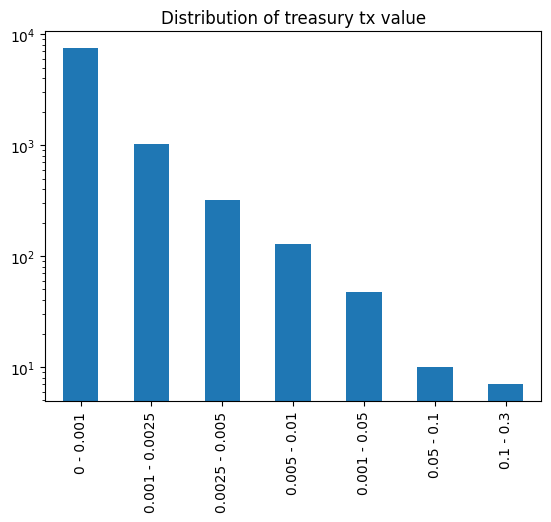

In [107]:
plt.yscale("log")  
plt.title('Distribution of treasury tx value')
pd.cut(to_treasury_tx_groupby['value'],bins=[0,0.001,0.0025,0.005,0.01,0.05,0.1,0.5],labels=[
    '0 - 0.001',
    '0.001 - 0.0025',
    '0.0025 - 0.005',
    '0.005 - 0.01',
    '0.001 - 0.05',
    '0.05 - 0.1',
    '0.1 - 0.3'
])\
.value_counts(sort=False).plot.bar()
plt.savefig('./plots/distrition_of_value_transfer.png')
plt.show()

In [13]:
address_tx_by_hour = pd.DataFrame(index=to_treasury_tx_groupby.index,columns=range(24)).fillna(0)
for address in to_treasury_tx_groupby.index:
    associate_tx_by_address = treasury_df[treasury_df['from']==address]
    hour_in_tx = pd.Series(associate_tx_by_address.index).apply(lambda x :x.hour)
    for hour in hour_in_tx:
        address_tx_by_hour.loc[address,hour]+=1

In [14]:
whales = to_treasury_tx_groupby.iloc[:10].index
whales_tx_by_hour = address_tx_by_hour.loc[whales]

In [25]:
treasury_df['hour']=  pd.Series(treasury_df.index).apply(lambda x:x.hour).values

In [37]:
def get_time_zone(average_hour,assumption):
    if assumption=='8-24':
        diff = round(average_hour - 16)
        return -diff 
    if assumption=='9-18':
        diff = round(average_hour - 13.5)
        return -diff
    if assumption=='average':
        return round(-round(average_hour - 16) + -round(average_hour - 13.5))/2
    

for address in whales:
    average_hour = treasury_df[treasury_df['from']==address]['hour'].mean()
    print(address,": ", "UTC+",get_time_zone(average_hour,'8-24'))

bd203e46efa084fcbeab85a75560a30bfd221ffa :  UTC+ 6
a09a9b6f90ab23fcdcd6c3d087c1dfb65dddfb05 :  UTC+ 4
63e1818f297f22795b2323b1ea5ef84e5f2f2365 :  UTC+ 7
fb734d416d3e782fc92f9351dd9e97259c50152c :  UTC+ 5
7f9f75e8303812ca8df692ab125321b503be21a8 :  UTC+ 8
5c2074b94edc36ad1a02cf74a2f283aafcd42443 :  UTC+ 6
85e084a6f65b47a1739de76a88c097d1f42d5bc2 :  UTC+ 7
6bdcf3ebc82ae2f3fea003f0f43710e57826a839 :  UTC+ -6
c879e46a254f9efdd03ffec0240161156e4081a4 :  UTC+ 5
ab77756d38c536384bd398ec4dc51a4ad884a75e :  UTC+ 6


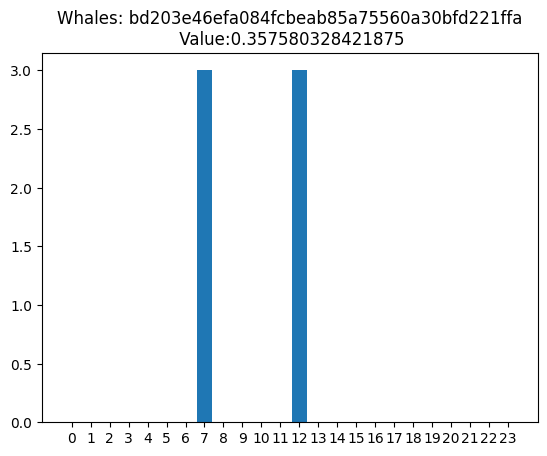

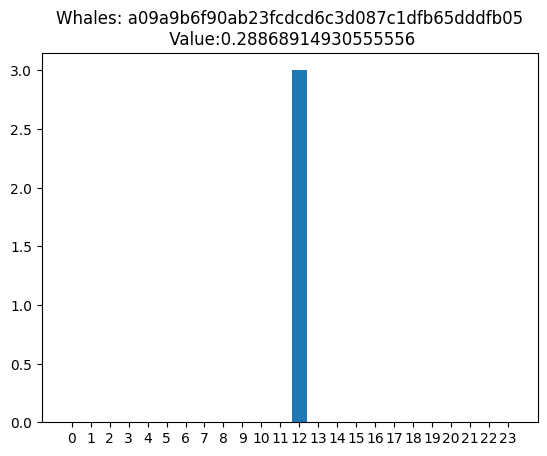

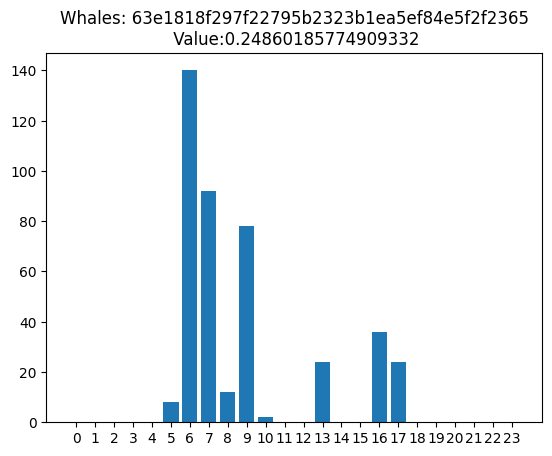

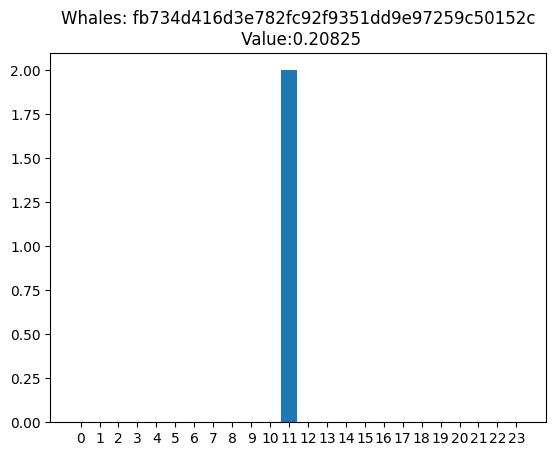

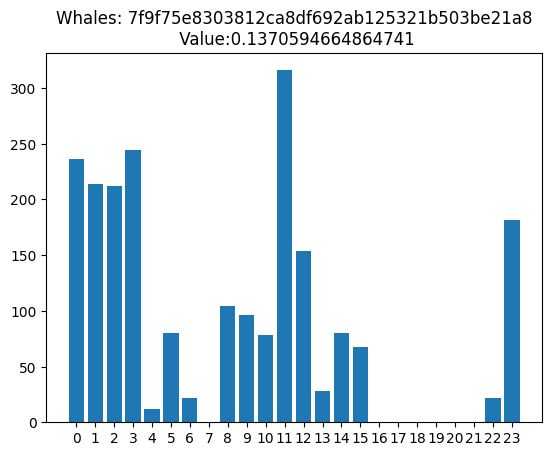

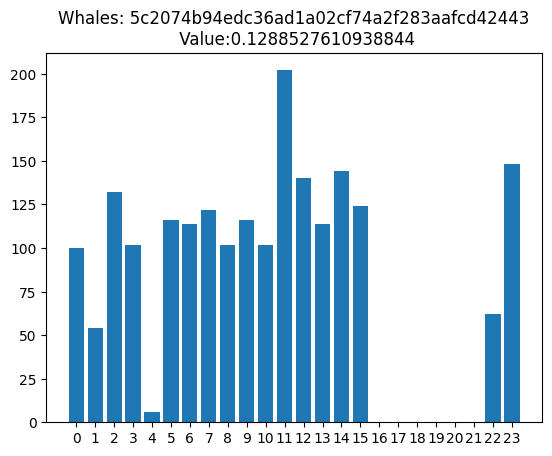

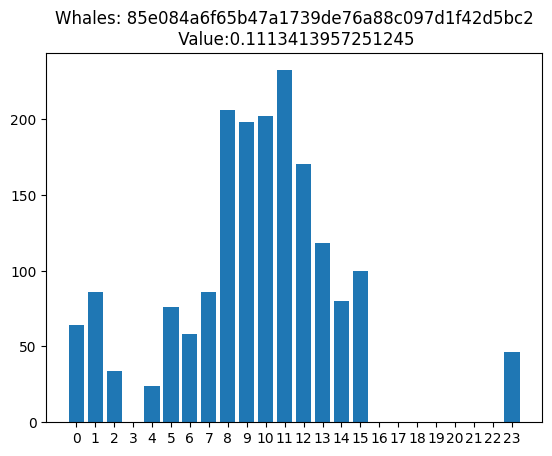

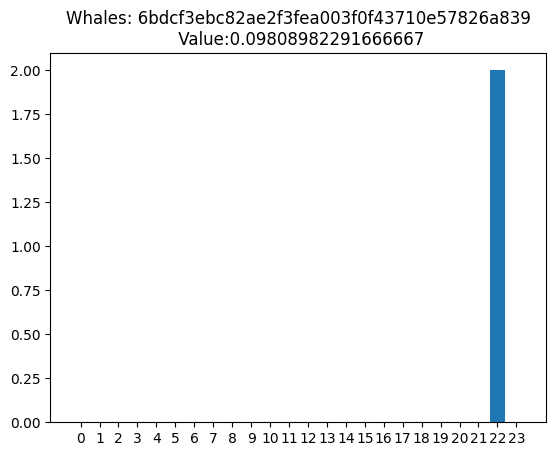

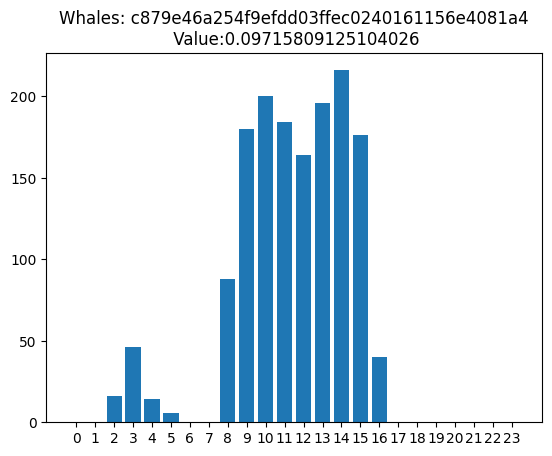

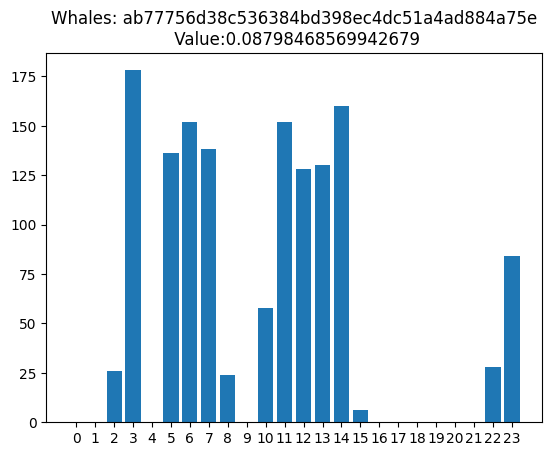

In [106]:
#plot tx hour range for each whale 

for i in range(len(whales_tx_by_hour)):
    plt.bar(range(24),whales_tx_by_hour.iloc[i])
    plt.xticks(range(24))
    plt.title(f'Whales: {whales_tx_by_hour.iloc[i].name}\n Value:{to_treasury_tx_groupby.loc[whales_tx_by_hour.iloc[i].name].value}')
    plt.savefig(f'./plots/trasaction_by_hour/{whales_tx_by_hour.iloc[i].name}.png')
    plt.show()

